# Flights

This notebook explores flight data from Dec 1, 2018 to Apr 1, 2019. With a limit of 400,000 observations, PostgreSQL retrieved information for the following months: January, March, and April.

Definitions:
- taxi out: the time between leaving the gate and take off
- wheels off: take off time off the ground

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orig_flight = pd.read_csv("./data/flight_data.csv")

orig_flight.shape

(400000, 42)

## Cleaning

In [3]:
orig_flight.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-18,UA,UA_CODESHARE,UA,4620,AX,N11113,4620,12896,LBB,...,456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-18,UA,UA_CODESHARE,UA,4619,AX,N12122,4619,11292,DEN,...,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-18,UA,UA_CODESHARE,UA,4618,AX,N846HK,4618,11267,DAY,...,240.0,74.0,0.0,11.0,0.0,90.0,NaN,NaN,NaN,NaN
3,2019-01-18,UA,UA_CODESHARE,UA,4617,AX,N11155,4617,11637,FAR,...,627.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-18,UA,UA_CODESHARE,UA,4616,AX,NaN,4616,13930,ORD,...,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
orig_flight.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code       object
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance

In [5]:
# change date dtype to datetime
orig_flight["fl_date"] = pd.to_datetime(orig_flight["fl_date"], format="%Y-%m-%d")

In [6]:
def percent_missing(df):
    n_missing = df.isnull().sum()
    percent_missing = n_missing / len(df) * 100

    return percent_missing.sort_values(ascending=False)

In [7]:
percent_missing(orig_flight)

no_name                100.00000
first_dep_time          99.25100
longest_add_gtime       99.25100
total_add_gtime         99.25100
cancellation_code       95.45750
late_aircraft_delay     77.67825
security_delay          77.67825
nas_delay               77.67825
weather_delay           77.67825
carrier_delay           77.67825
actual_elapsed_time      4.76050
arr_delay                4.76050
air_time                 4.76050
wheels_on                4.59175
taxi_in                  4.59175
arr_time                 4.59175
taxi_out                 4.51650
wheels_off               4.51650
dep_delay                4.45700
dep_time                 4.45650
tail_num                 1.14750
crs_elapsed_time         0.00200
diverted                 0.00000
flights                  0.00000
distance                 0.00000
dup                      0.00000
fl_date                  0.00000
cancelled                0.00000
mkt_unique_carrier       0.00000
crs_dep_time             0.00000
dest_city_

In [8]:
flight_df = orig_flight.copy()

In [9]:
# drop columns with highest number of nulls
flight_df.drop("no_name", axis=1, inplace=True)

flight_df.drop(["first_dep_time",
                "longest_add_gtime",
                "total_add_gtime",
                "cancellation_code"],
               axis=1,
               inplace=True)

In [10]:
# cancelled flights don't affect active flights, therefore, it's not useful for predicting delays
active_flights = flight_df[flight_df["cancelled"] == 0].reindex()

active_flights.drop(["cancelled"], axis=1, inplace=True)

In [11]:
active_flights.dup.unique() # entire column is flagged with "N"

array(['N'], dtype=object)

In [12]:
# removing columns containing duplicate information
active_flights.drop(["mkt_carrier", "op_carrier_fl_num", "branded_code_share"], axis=1, inplace=True)

In [13]:
# active_flights[["arr_time","crs_arr_time","arr_delay"]].head()

# removing time variables because they are accounted for in arr_delay and dep_delay
active_flights.drop(["crs_dep_time", "dep_time", "arr_time", "crs_arr_time"], axis=1, inplace=True)

In [14]:
final_flights = active_flights.copy()

In [15]:
final_flights = final_flights.drop(["wheels_off", "wheels_on"], axis=1)

In [16]:
# filter out missing arr_delay values
# final_flights = final_flights[final_flights["arr_delay"].notnull()].reset_index()

In [17]:
percent_missing(final_flights)

late_aircraft_delay    76.616033
security_delay         76.616033
nas_delay              76.616033
weather_delay          76.616033
carrier_delay          76.616033
arr_delay               0.228374
air_time                0.228374
actual_elapsed_time     0.228374
taxi_in                 0.051594
dest                    0.000000
dest_city_name          0.000000
mkt_carrier_fl_num      0.000000
op_unique_carrier       0.000000
tail_num                0.000000
origin_airport_id       0.000000
distance                0.000000
flights                 0.000000
origin                  0.000000
origin_city_name        0.000000
crs_elapsed_time        0.000000
dup                     0.000000
diverted                0.000000
dest_airport_id         0.000000
mkt_unique_carrier      0.000000
taxi_out                0.000000
dep_delay               0.000000
fl_date                 0.000000
dtype: float64

In [18]:
final_flights["arr_delay"].isnull().sum()

872

In [19]:
final_flights["arr_delay"] = final_flights["arr_delay"].fillna(0)

In [20]:
final_flights.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,...,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2019-01-18,UA,4620,AX,N11113,12896,LBB,"Lubbock, TX",11292,DEN,...,100.0,87.0,67.0,1.0,456.0,NaN,NaN,NaN,NaN,NaN
1,2019-01-18,UA,4619,AX,N12122,11292,DEN,"Denver, CO",11413,DRO,...,78.0,67.0,47.0,1.0,250.0,NaN,NaN,NaN,NaN,NaN
2,2019-01-18,UA,4618,AX,N846HK,11267,DAY,"Dayton, OH",13930,ORD,...,81.0,92.0,64.0,1.0,240.0,74.0,0.0,11.0,0.0,90.0
3,2019-01-18,UA,4617,AX,N11155,11637,FAR,"Fargo, ND",11292,DEN,...,136.0,133.0,99.0,1.0,627.0,NaN,NaN,NaN,NaN,NaN
5,2019-01-18,UA,4615,AX,N18101,11292,DEN,"Denver, CO",13367,MLI,...,122.0,118.0,97.0,1.0,752.0,43.0,0.0,0.0,0.0,0.0


## Exploration

In [21]:
final_flights.shape

(381830, 27)

In [22]:
final_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'origin_airport_id', 'origin',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'dep_delay', 'taxi_out', 'taxi_in', 'arr_delay', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

<AxesSubplot:xlabel='dep_delay', ylabel='arr_delay'>

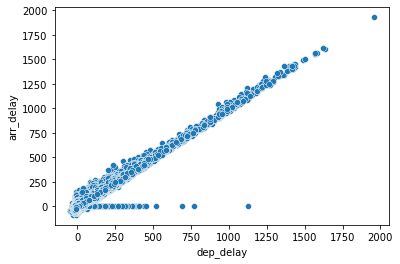

In [23]:
# relationship between departure and arrival delay
sns.scatterplot(x=final_flights.dep_delay, y=final_flights.arr_delay)

In [24]:
out = final_flights[(final_flights.arr_delay>1750) & (final_flights.dep_delay>1750)]

out

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,...,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
395725,2019-03-05,AA,284,AA,N129AA,12173,HNL,"Honolulu, HI",12892,LAX,...,334.0,303.0,278.0,1.0,2556.0,1928.0,0.0,0.0,0.0,0.0


In [25]:
out.dest_city_name

395725    Los Angeles, CA
Name: dest_city_name, dtype: object

The relationship between arrival delay and departure delay is positive. As departure is delayed, the later the flight will arrive at its destination, on average. As seen in the scatterplot, one of the flights had a longer delay than the rest. The corresponding flight originates from Honolulu, with a distance of 2556 miles to its destination in Los Angeles.

In [26]:
final_flights["arr_delay"].describe()

count    381830.000000
mean         10.027334
std          59.226334
min         -87.000000
25%         -14.000000
50%          -5.000000
75%          12.000000
max        1928.000000
Name: arr_delay, dtype: float64

<AxesSubplot:xlabel='arr_delay', ylabel='Count'>

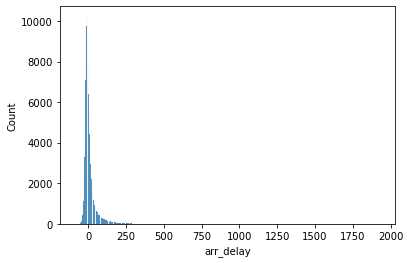

In [27]:
sns.histplot(final_flights.arr_delay)
# plt.xlim(-100, 200)

The distribution of arr_delay is skewed right with a mean of around 10 and a standard deviation around 59.2.

In [28]:
from scipy import stats

# test if arr_delay is from the normal distribution
alpha = 0.05
data = final_flights.arr_delay
norm_test = stats.normaltest(data)

if norm_test.pvalue < alpha:
    print(f"At the {alpha} significance level, there is insufficient " 
          "evidence to suggest that the arrival delay is from the normal distribution.")
else:
    print(f"At the {alpha} significance level, there is sufficient evidence to suggest that, "
          "the arrival delay is from the normal distribution.")

At the 0.05 significance level, there is insufficient evidence to suggest that the arrival delay is from the normal distribution.


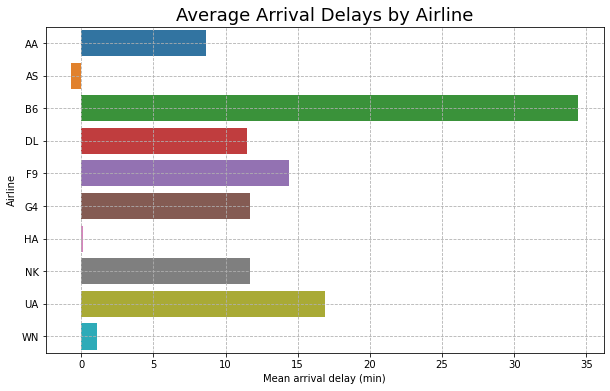

In [29]:
# comparing arrival delays by airline
arr_delay_df = final_flights[["fl_date", "mkt_unique_carrier", "arr_delay"]]
avg_delay = arr_delay_df.groupby("mkt_unique_carrier").mean().reset_index()


fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x="arr_delay", y="mkt_unique_carrier", data=avg_delay)
ax.grid(linestyle="--")
ax.set_title("Average Arrival Delays by Airline", fontsize=18)
ax.set_ylabel("Airline")
ax.set_xlabel("Mean arrival delay (min)")

plt.show()

#### Monthly Arrival Delay

In [30]:
# monthly arrival delay
arr_delay_df["day"] = arr_delay_df.loc[:, "fl_date"].dt.day
arr_delay_df["month"] = arr_delay_df.loc[:, "fl_date"].dt.month
arr_delay_df["year"] = arr_delay_df["fl_date"].dt.year

C:\Users\vanessa\AppData\Local\Temp\ipykernel_9120\4162549207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_delay_df["day"] = arr_delay_df.loc[:, "fl_date"].dt.day
C:\Users\vanessa\AppData\Local\Temp\ipykernel_9120\4162549207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr_delay_df["month"] = arr_delay_df.loc[:, "fl_date"].dt.month
C:\Users\vanessa\AppData\Local\Temp\ipykernel_9120\4162549207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [31]:
arr_delay_df.month.unique()

array([1, 4, 3], dtype=int64)

In [32]:
monthly_delay = arr_delay_df.groupby(["month"]).mean().sort_values(by="month").reset_index()
monthly_delay

,month,arr_delay,day,year
0,1,9.118168,24.883402,2019.0
1,3,11.763536,2.985143,2019.0
2,4,12.480273,1.000000,2019.0


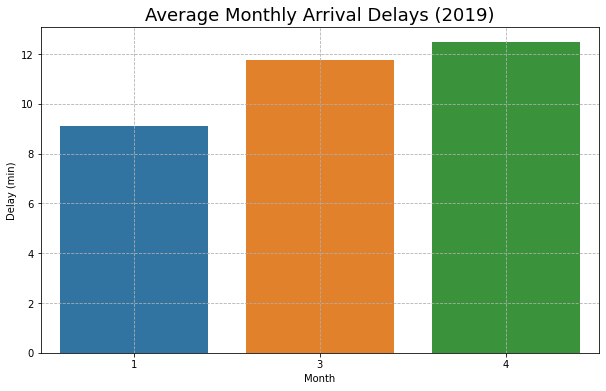

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x="month", y="arr_delay", data=monthly_delay)
ax.grid(linestyle="--")
ax.set_title("Average Monthly Arrival Delays (2019)", fontsize=18)
ax.set_ylabel("Delay (min)")
ax.set_xlabel("Month")

plt.show()

#### More cleaning

In [34]:
flights_clean = final_flights.copy()

In [35]:
flights_clean.drop(["carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"], axis=1, inplace=True)

In [36]:
# separate dates into columns
flights_clean["day"] = flights_clean.loc[:, "fl_date"].dt.day
flights_clean["month"] = flights_clean.loc[:, "fl_date"].dt.month
flights_clean["year"] = flights_clean["fl_date"].dt.year

In [37]:
flights_clean.to_csv("./data/flights_clean.csv", index=False)